In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time
import urllib.request




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7f3dc7ba0b10>)

In [4]:
lines = open("tinyshakespeare.txt", "r").read()

vocab = sorted(list(set(lines)))

print(f'First 10 characters {vocab[:10]}')

print(f'Total characters {len(vocab)}')

First 10 characters ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total characters 65


In [5]:
#creating a simple character level tokenizer

# int to char
itoch = {i: ch for i, ch in enumerate(vocab)}

#char to int
chtoi = {ch: i for i, ch in enumerate(vocab)}

def encode(s):
    return [chtoi[ch] for ch in s]

def decode(l):
    return ''.join([itoch[i] for i in l])

#test
decode(encode("bonjour bonjour"))

'bonjour bonjour'

In [6]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(dataset.shape)

torch.Size([1115394])


In [7]:
MASTER_CONFIG = {
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16      # Number of characters in each input (x) and target (y) sequence of each batch
}

In [8]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.eps = eps
        
        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [9]:

# class RMSNorm(torch.nn.Module):
#     def __init__(self, dim: int, eps: float = 1e-6):
#         """
#         Initialize the RMSNorm normalization layer.

#         Args:
#             dim (int): The dimension of the input tensor.
#             eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

#         Attributes:
#             eps (float): A small value added to the denominator for numerical stability.
#             weight (nn.Parameter): Learnable scaling parameter.

#         """
#         super().__init__()
#         self.eps = eps
#         self.weight = nn.Parameter(torch.ones(dim))

#     def _norm(self, x):
#         """
#         Apply the RMSNorm normalization to the input tensor.

#         Args:
#             x (torch.Tensor): The input tensor.

#         Returns:
#             torch.Tensor: The normalized tensor.

#         """
#         return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

#     def forward(self, x):
#         """
#         Forward pass through the RMSNorm layer.

#         Args:
#             x (torch.Tensor): The input tensor.

#         Returns:
#             torch.Tensor: The output tensor after applying RMSNorm.

#         """
#         output = self._norm(x.float()).type_as(x)
#         return output * self.weight

In [10]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,), device=device)

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x.to(device), y.to(device)
    

In [11]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}
    
    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            
            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)
            
            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)
    
    # Set the model back to training mode
    model.train()
    
    return out

In [12]:
# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []
    
    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time
            
            # Evaluate loss on validation set
            x = evaluate_loss(model)
            
            # Store the validation loss
            losses += [x]
            
            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
                
            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])
    
    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
# train(model, optimizer)

In [13]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1, device=device).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:]).to(device)
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
# generate(model)

In [14]:
class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False, device=device)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False, device=device)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False, device=device)
        # Obtain rotary matrix for positional embeddings
        self.R = self.get_rotary_matrix(config['context_window'], config['d_model'])
        
    def get_rotary_matrix(self, context_window, embedding_dim):
        # Initialize a tensor for the rotary matrix with zeros
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False, device=device)
        
        # Loop through each position in the context window
        for position in range(context_window):
            # Loop through each dimension in the embedding
            for i in range(embedding_dim // 2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

In [15]:
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        
        # Apply linear transformation to the concatenated output
        x = self.linear(x)
        
        # Apply dropout
        x = self.dropout(x)
        return x

In [16]:
class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        # self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out

In [17]:

class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x_norm = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x_norm)  # residual connection

        x_norm = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x_norm)  # residual connection
        return x

In [18]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            RMSNorm((config['context_window'], config['d_model'])),
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

In [19]:
MASTER_CONFIG

{'batch_size': 8, 'context_window': 16}

In [20]:
# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16,
    'vocab_size': 65,
    'd_model': 128,
    'epochs': 40000,
    'n_heads': 32,
    'n_layers': 16,
    'log_interval': 10
    
})

model params: 34450130
Epoch 0 | val loss 4.160 | Time 0.849 | ETA in seconds 3394.051
Epoch 10 | val loss 3.629 | Time 6.583 | ETA in seconds 26326.614
Epoch 20 | val loss 3.412 | Time 6.702 | ETA in seconds 26793.461
Epoch 30 | val loss 3.477 | Time 6.905 | ETA in seconds 27601.166
Epoch 40 | val loss 3.343 | Time 7.252 | ETA in seconds 28979.503
Epoch 50 | val loss 3.341 | Time 6.885 | ETA in seconds 27503.801
Epoch 60 | val loss 3.329 | Time 7.123 | ETA in seconds 28450.707
Epoch 70 | val loss 3.455 | Time 6.733 | ETA in seconds 26884.228
Epoch 80 | val loss 3.364 | Time 6.414 | ETA in seconds 25603.616
Epoch 90 | val loss 3.259 | Time 6.419 | ETA in seconds 25620.220
Epoch 100 | val loss 3.426 | Time 6.356 | ETA in seconds 25359.046
Epoch 110 | val loss 3.385 | Time 6.351 | ETA in seconds 25333.906
Epoch 120 | val loss 3.346 | Time 6.623 | ETA in seconds 26414.095
Epoch 130 | val loss 3.343 | Time 6.408 | ETA in seconds 25547.762
Epoch 140 | val loss 3.338 | Time 6.760 | ETA in se

<Axes: >

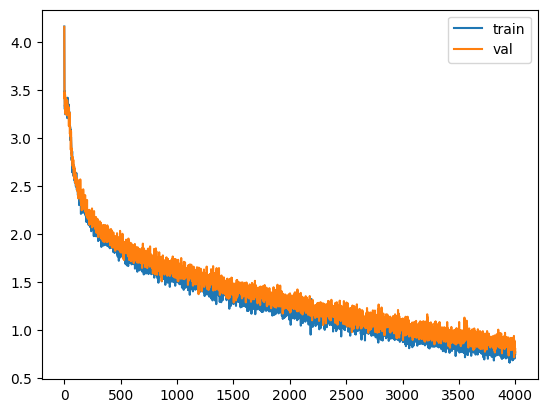

In [21]:

# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG).cuda()

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    # weight_decay=.1,
    # eps=1e-9,
    # lr=1e-3
)
# Train the LLaMA model for the specified number of epochs
train(llama, llama_optimizer, print_logs=True)

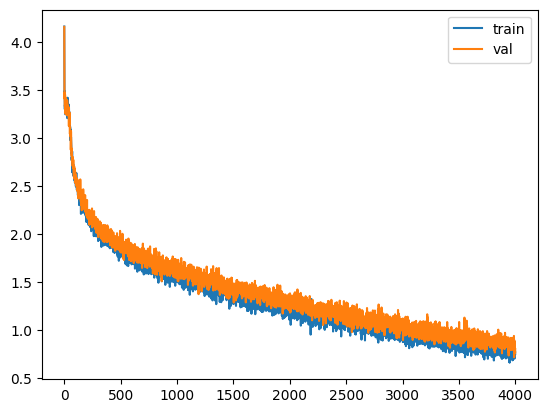

In [3]:
torch.cuda.reset_accumulated_memory_stats()

In [119]:
x = torch.randint(1, 1000, (100, 100))
print('Device Name: ' , x.device)

Device Name:  cpu


In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [121]:
device


'cuda'

In [54]:
# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'epochs': 15000,
    
    
})
train(llama, llama_optimizer, print_logs=True)

Epoch 0 | val loss 0.868 | Time 0.603 | ETA in seconds 301.509
Epoch 10 | val loss 0.755 | Time 6.269 | ETA in seconds 3128.445


KeyboardInterrupt: 

In [24]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 250)
print(generated_text)

["\nVongalchapblid blifdsidyed instos! bs ey main'ser edlukeing that now hince their he You thall! I' I weel in\ndend I wichindsto yeaFLEsed bade. SaMEON:\nGonk sore s reight, ' for fecigel and weer, will aw'?t pengerennen. Mord nother.\nDaHE!Iquck she, ey ", "\nFoucanvargan now to Lik:\nDarisly, 'Jcayongud-hy'd dajonky the the I ham: se here hidut yhou\n havery:ss py have sullain:\nThey mamph ans of lorg\nus.AAN:\nAHHip so no, I mild?\nYorcy were atiung.\n\nWAPRCIL:\nAond how\nI then they Ro therlord no Meeterd,\n-\nWA", "\nOvanKangacia 'nathid;\nAGREO HAMOws timed\nHad digh to, why let the Dim giver\nAs that brearers,\nHad feillaanoury that knly Ulls you vend tell, fid ist;\nDeteme'dr? Thy is wath, I,'ll off Migooron's gadlenushen But affar'd pleigh andth froy!\n\nNurn col ma", "\n\nJOLIXEOESSENIUS:\nHerrow co mend woL'thfual'dringber meis thee sabundeitersw-Fend\nthath thou roth his Supis\nANEr it bof tusse.\nBecingerner.\n\nTICLALEN:\nNo then lengled the hishen,\nThe kpons, eyBel h

In [27]:
print("".join( generated_text))


Vongalchapblid blifdsidyed instos! bs ey main'ser edlukeing that now hince their he You thall! I' I weel in
dend I wichindsto yeaFLEsed bade. SaMEON:
Gonk sore s reight, ' for fecigel and weer, will aw'?t pengerennen. Mord nother.
DaHE!Iquck she, ey 
Foucanvargan now to Lik:
Darisly, 'Jcayongud-hy'd dajonky the the I ham: se here hidut yhou
 havery:ss py have sullain:
They mamph ans of lorg
us.AAN:
AHHip so no, I mild?
Yorcy were atiung.

WAPRCIL:
Aond how
I then they Ro therlord no Meeterd,
-
WA
OvanKangacia 'nathid;
AGREO HAMOws timed
Had digh to, why let the Dim giver
As that brearers,
Had feillaanoury that knly Ulls you vend tell, fid ist;
Deteme'dr? Thy is wath, I,'ll off Migooron's gadlenushen But affar'd pleigh andth froy!

Nurn col ma

JOLIXEOESSENIUS:
Herrow co mend woL'thfual'dringber meis thee sabundeitersw-Fend
thath thou roth his Supis
ANEr it bof tusse.
Becingerner.

TICLALEN:
No then lengled the hishen,
The kpons, eyBel hend Iwho nellemadat eneceer MOnod no forror thop 

looks good but needs a better tokenizer

In [29]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
